### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Apr 10 14:39:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 76.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [4]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-04-10 14:45:23--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-04-10 14:45:23 (120 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

## Download dataset from Roboflow Universe

In [5]:


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8WMeoaLlkwmzFWwG6P5h")
project = rf.workspace("fastnuces-uakqb").project("fyp-shoplift")
version = project.version(1)
dataset = version.download("yolov11")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FYP-Shoplift-1 in yolov11:: 100%|██████████| 1674/1674 [00:00<00:00, 7159.96it/s]


In [6]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [7]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [8]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['normal', 'shoplifting']

roboflow:
  workspace: fastnuces-uakqb
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [9]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=120)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.106 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/FYP-Shoplift-1/data.yaml, epochs=120, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, a

100%|██████████| 755k/755k [00:00<00:00, 21.3MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 104MB/s]


AMP: checks passed ✅


train: Scanning /content/FYP-Shoplift-1/train/labels... 584 images, 2 backgrounds, 0 corrupt: 100%|██████████| 584/584 [00:00<00:00, 2397.41it/s]

train: New cache created: /content/FYP-Shoplift-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/FYP-Shoplift-1/valid/labels... 167 images, 0 backgrounds, 0 corrupt: 100%|██████████| 167/167 [00:00<00:00, 2059.68it/s]

val: New cache created: /content/FYP-Shoplift-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      6.74G      3.064      3.711      4.209         16        640: 100%|██████████| 37/37 [00:21<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]

                   all        167        168    0.00182      0.578     0.0072    0.00354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      6.64G      3.002      3.522      4.009         20        640: 100%|██████████| 37/37 [00:20<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all        167        168    0.00181      0.578     0.0293     0.0057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      6.67G      2.803      3.263      3.672         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


                   all        167        168    0.00215      0.639     0.0667     0.0207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      6.64G       2.61      3.013      3.353         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168    0.00384      0.745     0.0287    0.00681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      6.82G      2.415      2.908      3.102         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        167        168       0.21       0.14     0.0913     0.0362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      6.83G      2.315      2.677      2.954         29        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all        167        168      0.614      0.343      0.178     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      6.83G      2.253      2.535      2.826         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        167        168      0.479      0.512      0.389      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      6.79G      2.112      2.317      2.661         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        167        168      0.375      0.407      0.347      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      6.83G      1.979      2.186      2.568         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all        167        168      0.575       0.44      0.441      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      6.67G        1.9       2.11      2.446         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

                   all        167        168      0.454       0.52      0.434      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      6.66G      1.814      2.024       2.37         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        167        168      0.462      0.627       0.51      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      6.79G      1.715      1.971      2.268         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

                   all        167        168      0.734       0.37      0.492      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      6.67G      1.557        1.8      2.154         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        167        168      0.754      0.631      0.546      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      6.66G      1.514      1.747      2.085         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

                   all        167        168      0.728       0.54      0.573      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      6.83G      1.366      1.627      1.983         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

                   all        167        168      0.615      0.395      0.423      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      6.64G       1.29      1.529       1.89         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


                   all        167        168      0.648      0.579      0.537      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      6.65G       1.23      1.462      1.833         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        167        168      0.617       0.61      0.612      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      6.83G      1.117      1.385      1.723         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.696       0.63      0.636      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      6.66G      1.037      1.322      1.656         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.704      0.687      0.694      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      6.64G      1.008      1.249      1.635         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        167        168      0.759      0.656      0.648      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      6.82G     0.9015      1.151      1.524         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.797       0.68      0.691      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      6.66G     0.8687      1.143      1.515         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168      0.734      0.674      0.651      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      6.66G     0.8629      1.115      1.502         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.665      0.682      0.655      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      6.79G     0.7991      1.084      1.446         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        167        168      0.698      0.692      0.684      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      6.83G     0.8302      1.109      1.481         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.626       0.67      0.679      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      6.83G     0.7677      1.058      1.427         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168      0.714      0.645      0.711      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      6.83G      0.762      1.023      1.422         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        167        168       0.67      0.701      0.645      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      6.79G     0.7004     0.9588      1.375         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all        167        168      0.806       0.68      0.704       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      6.67G     0.6918     0.9342      1.358         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.732      0.753      0.747        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      6.83G     0.6947     0.9351      1.362         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

                   all        167        168      0.779      0.679      0.702      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      6.83G     0.7217     0.9591      1.351         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168      0.728      0.695      0.712      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      6.64G     0.6421     0.8954      1.312         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

                   all        167        168      0.666       0.73      0.704      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      6.65G     0.6452     0.9073      1.326         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        167        168      0.843      0.692      0.745      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      6.83G     0.6203     0.8959      1.297         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        167        168      0.755       0.73      0.756       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      6.66G      0.633     0.8762      1.286         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        167        168      0.752      0.738      0.748      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      6.64G     0.6744     0.8859       1.34         16        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

                   all        167        168      0.756      0.739      0.758      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      6.82G     0.6201     0.8457      1.289         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all        167        168      0.713      0.798      0.799      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      6.66G     0.5724     0.8118      1.255         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all        167        168      0.741       0.73      0.757      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      6.83G     0.5922     0.8165       1.25         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.833      0.738        0.8      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      6.64G     0.5611     0.7961      1.235         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.811      0.745      0.802      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      6.82G     0.5567     0.7742      1.224         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

                   all        167        168      0.863      0.725      0.756       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      6.83G     0.5458     0.7925      1.233         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

                   all        167        168      0.769      0.771      0.795      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      6.83G     0.5261     0.7802      1.201         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

                   all        167        168      0.815      0.798      0.824       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      6.64G     0.5437     0.7604      1.226         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.657      0.851      0.808       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      6.82G     0.5506     0.7967      1.224         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.70it/s]

                   all        167        168      0.799      0.813      0.843      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      6.66G     0.5231     0.7664      1.199         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


                   all        167        168      0.817      0.775      0.813      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      6.66G     0.5098     0.7204      1.202         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        167        168      0.772      0.866      0.856      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      6.64G     0.5168     0.7202      1.205         27        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all        167        168        0.8      0.826      0.867      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      6.82G     0.5083     0.7311      1.191         28        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        167        168      0.806      0.787      0.853      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      6.66G     0.4874      0.704      1.177         27        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        167        168      0.727      0.838      0.857      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      6.66G     0.5171     0.7433      1.199         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        167        168      0.828      0.791      0.875      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      6.64G     0.4847     0.7239      1.171         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all        167        168        0.8      0.851      0.867      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      6.82G     0.4753     0.6981      1.165         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all        167        168      0.783       0.82       0.85      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      6.66G     0.5086     0.7118      1.181         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        167        168      0.763       0.87      0.868      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      6.83G     0.4832     0.6701      1.163         15        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.813      0.757      0.832      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      6.64G     0.4927     0.6976      1.173         16        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.71it/s]

                   all        167        168      0.838      0.806      0.864      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      6.82G     0.4592     0.6864      1.161         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        167        168      0.772      0.881      0.895      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      6.83G     0.4125     0.6436      1.111         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        167        168      0.877      0.831      0.882      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      6.83G     0.4594     0.6893      1.147         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.807      0.865      0.902      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      6.64G     0.4455     0.6656      1.127         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.822      0.847      0.886      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      6.82G     0.4273     0.6481      1.129         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.797      0.897      0.916      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      6.83G     0.4454     0.6434      1.131         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all        167        168      0.854      0.806      0.891      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      6.83G     0.4531      0.661      1.144         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all        167        168      0.845      0.816      0.882      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      6.64G     0.4644     0.6602      1.153         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.805      0.874      0.912      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      6.82G     0.4247     0.6109      1.113         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.784      0.877      0.893      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      6.66G     0.4452     0.6713      1.134         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.70it/s]

                   all        167        168      0.826      0.839      0.872      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      6.66G     0.4387     0.6291      1.131         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

                   all        167        168      0.749      0.889      0.895      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      6.64G     0.4299     0.5938      1.114         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all        167        168      0.799      0.836      0.892      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      6.82G     0.4218     0.6182       1.11         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.724      0.904      0.883      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      6.66G      0.437      0.612      1.126         16        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.808      0.866      0.907      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      6.66G     0.4272     0.6055       1.12         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        167        168      0.804      0.897       0.92      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      6.64G     0.4095     0.6113      1.105         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.901      0.864      0.929      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      6.82G     0.4147     0.6035      1.113         15        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        167        168      0.851      0.792      0.897      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      6.83G     0.4233     0.6063      1.107         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

                   all        167        168      0.855      0.834      0.929       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      6.66G     0.4108     0.6058      1.114         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  3.00it/s]

                   all        167        168      0.821      0.852      0.918      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      6.64G     0.4303     0.6112       1.12         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.741      0.919      0.912      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      6.82G       0.39     0.5535      1.099         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        167        168      0.799      0.922      0.922      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      6.66G     0.3888     0.5723      1.087         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        167        168      0.833      0.911      0.925      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      6.66G      0.389     0.5888      1.094         19        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all        167        168      0.784       0.91      0.917      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      6.64G     0.3953     0.5896       1.11         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

                   all        167        168      0.878      0.866      0.933      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      6.82G     0.3805     0.5684      1.096         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.802      0.912      0.925      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      6.67G     0.3844     0.5648      1.087         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.841      0.883      0.924      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      6.83G     0.3761     0.5685      1.094         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

                   all        167        168      0.873      0.884      0.934      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      6.64G     0.3748     0.5581      1.083         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all        167        168      0.844      0.846      0.906      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      6.82G     0.3807      0.568       1.09         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.921      0.852      0.935       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      6.83G     0.3873     0.5898      1.104         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.843      0.851      0.929      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120      6.83G     0.3725     0.5804      1.083         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.86it/s]

                   all        167        168      0.797      0.942      0.936      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      6.64G     0.3927      0.559      1.102         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        167        168      0.912      0.827      0.922      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      6.82G     0.3842     0.5511      1.084         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.832      0.915      0.944      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      6.66G     0.3623     0.5443      1.074         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        167        168      0.829      0.934      0.949      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      6.66G     0.3836     0.5706      1.092         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

                   all        167        168       0.92      0.867      0.942      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      6.64G     0.3652      0.552       1.08         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        167        168      0.867      0.844      0.922      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      6.82G     0.3703     0.5302      1.079         18        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all        167        168       0.86      0.899      0.947      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      6.83G     0.3459     0.5006      1.054         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        167        168      0.891      0.926       0.95       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      6.67G      0.366     0.5273      1.083         15        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all        167        168      0.914      0.879       0.95      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      6.64G     0.3301     0.4957      1.054         17        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

                   all        167        168      0.859      0.913      0.946       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      6.82G     0.3499     0.5217      1.065         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

                   all        167        168      0.923      0.872      0.941      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      6.66G     0.3404     0.5119      1.062         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

                   all        167        168      0.927      0.837      0.936      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      6.67G     0.3402     0.4944      1.058         25        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

                   all        167        168      0.895      0.916      0.949      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      6.64G     0.3345     0.5146      1.061         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all        167        168      0.943      0.884      0.944      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      6.82G     0.3582     0.5339       1.06         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        167        168       0.92      0.887      0.947      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      6.83G      0.357     0.5432      1.073         26        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.869      0.879       0.94      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      6.66G     0.3329     0.4931      1.046         14        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all        167        168      0.872      0.901      0.943      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      6.64G     0.3492     0.5097      1.047         15        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

                   all        167        168      0.866      0.955      0.956      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      6.82G     0.3449     0.4956      1.058         21        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        167        168      0.928      0.882      0.954      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      6.66G     0.3268     0.4843      1.047         24        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all        167        168       0.92      0.897       0.95       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      6.66G     0.3337     0.4808      1.045         23        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

                   all        167        168      0.918      0.924      0.959      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      6.64G     0.3418     0.4889      1.051         20        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

                   all        167        168      0.912      0.892      0.949      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      6.82G     0.3044     0.4686      1.035         22        640: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        167        168      0.898      0.945      0.959      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      6.66G     0.3312     0.4742      1.043         28        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

                   all        167        168      0.847       0.96       0.95      0.848


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      6.66G     0.4407     0.6781      1.153          8        640: 100%|██████████| 37/37 [00:20<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.896      0.898      0.941      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      6.64G     0.3787     0.4581      1.098          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.926      0.912      0.941      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      6.82G      0.348      0.412      1.072          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

                   all        167        168      0.929      0.888      0.949      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      6.66G     0.3312     0.3898      1.071          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        167        168      0.937       0.91      0.957      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      6.66G     0.3305     0.3878      1.072          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        167        168      0.903      0.915      0.954      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      6.64G      0.335     0.3765      1.074          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]

                   all        167        168      0.932      0.907      0.958      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      6.82G      0.311     0.3644      1.048          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

                   all        167        168       0.93       0.89      0.954       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      6.83G     0.3186     0.3691      1.055          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        167        168      0.938      0.901      0.956      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      6.83G     0.3083     0.3465      1.045          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

                   all        167        168      0.925      0.894      0.953      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      6.64G     0.3136     0.3485      1.046          8        640: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

                   all        167        168      0.916      0.905      0.955      0.859



120 epochs completed in 0.748 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,982 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


                   all        167        168      0.925      0.894      0.954      0.859
                normal        101        102      0.942      0.955      0.975      0.974
           shoplifting         66         66      0.908      0.833      0.932      0.744
Speed: 0.2ms preprocess, 6.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [10]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   R_curve.png		val_batch0_labels.jpg
confusion_matrix_normalized.png			   results.csv		val_batch0_pred.jpg
confusion_matrix.png				   results.png		val_batch1_labels.jpg
events.out.tfevents.1744277316.150e0f70eba2.268.0  train_batch0.jpg	val_batch1_pred.jpg
F1_curve.png					   train_batch1.jpg	val_batch2_labels.jpg
labels_correlogram.jpg				   train_batch2220.jpg	val_batch2_pred.jpg
labels.jpg					   train_batch2221.jpg	weights
P_curve.png					   train_batch2222.jpg
PR_curve.png					   train_batch2.jpg


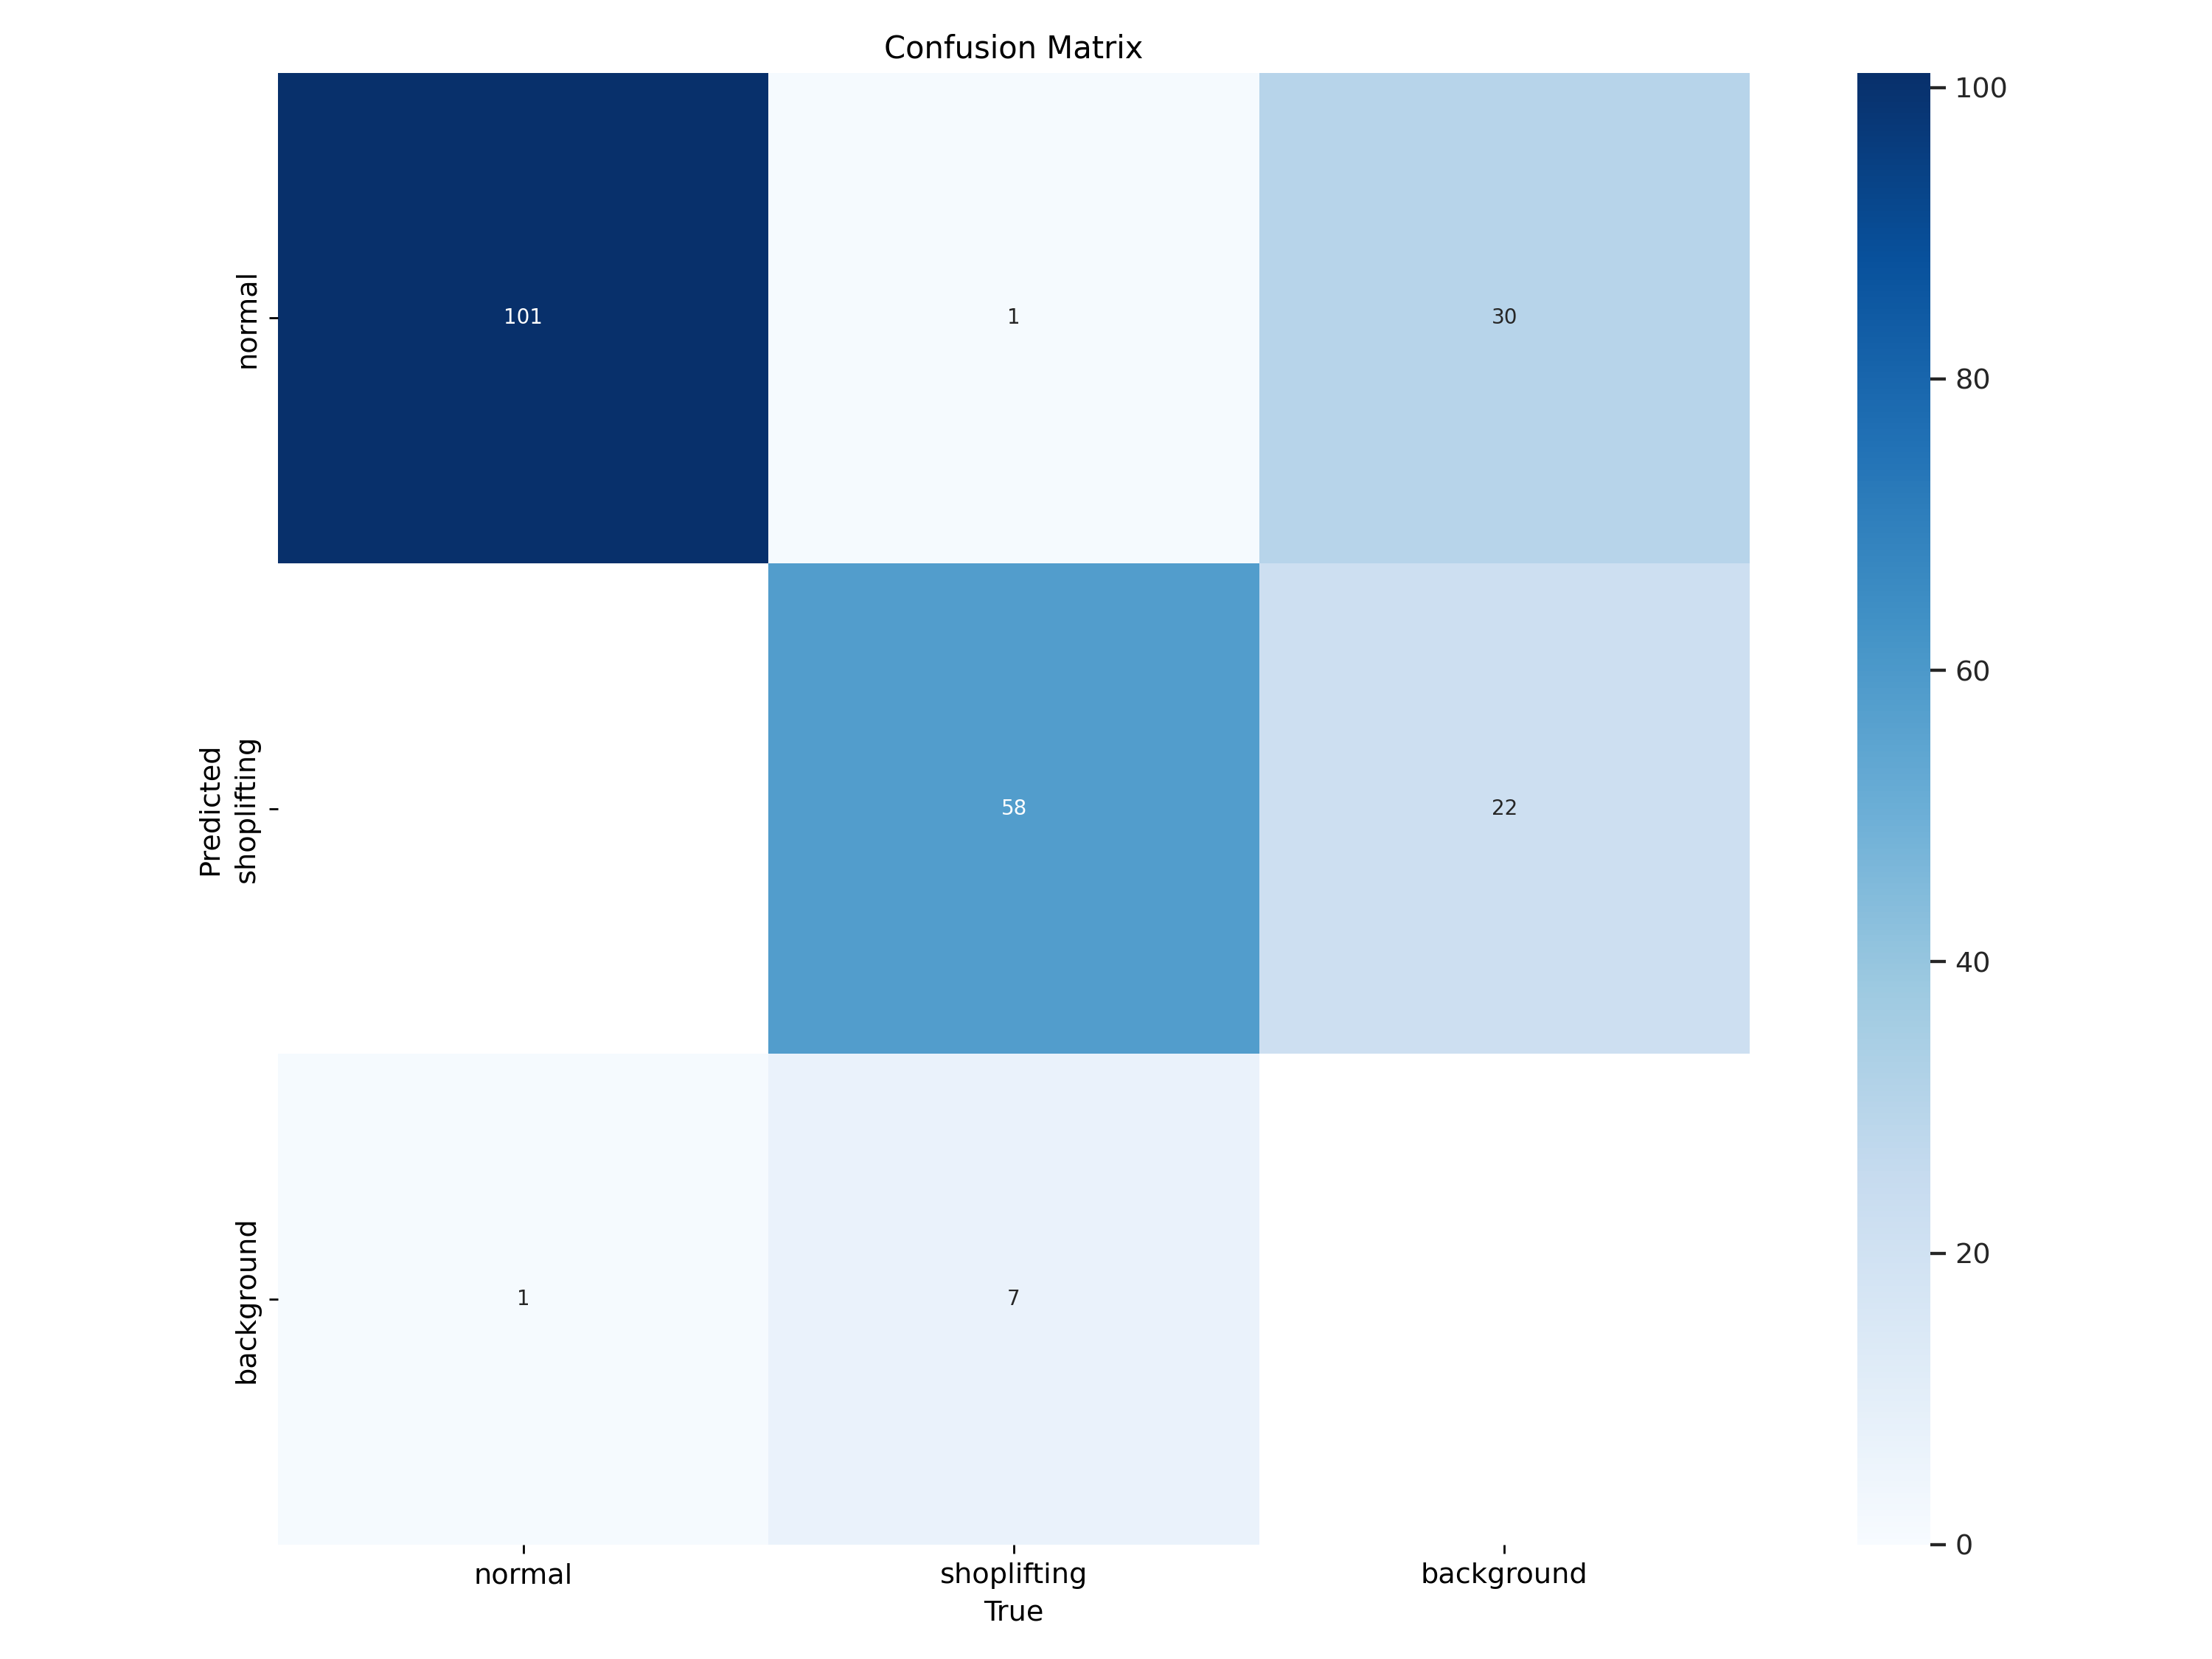

In [11]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

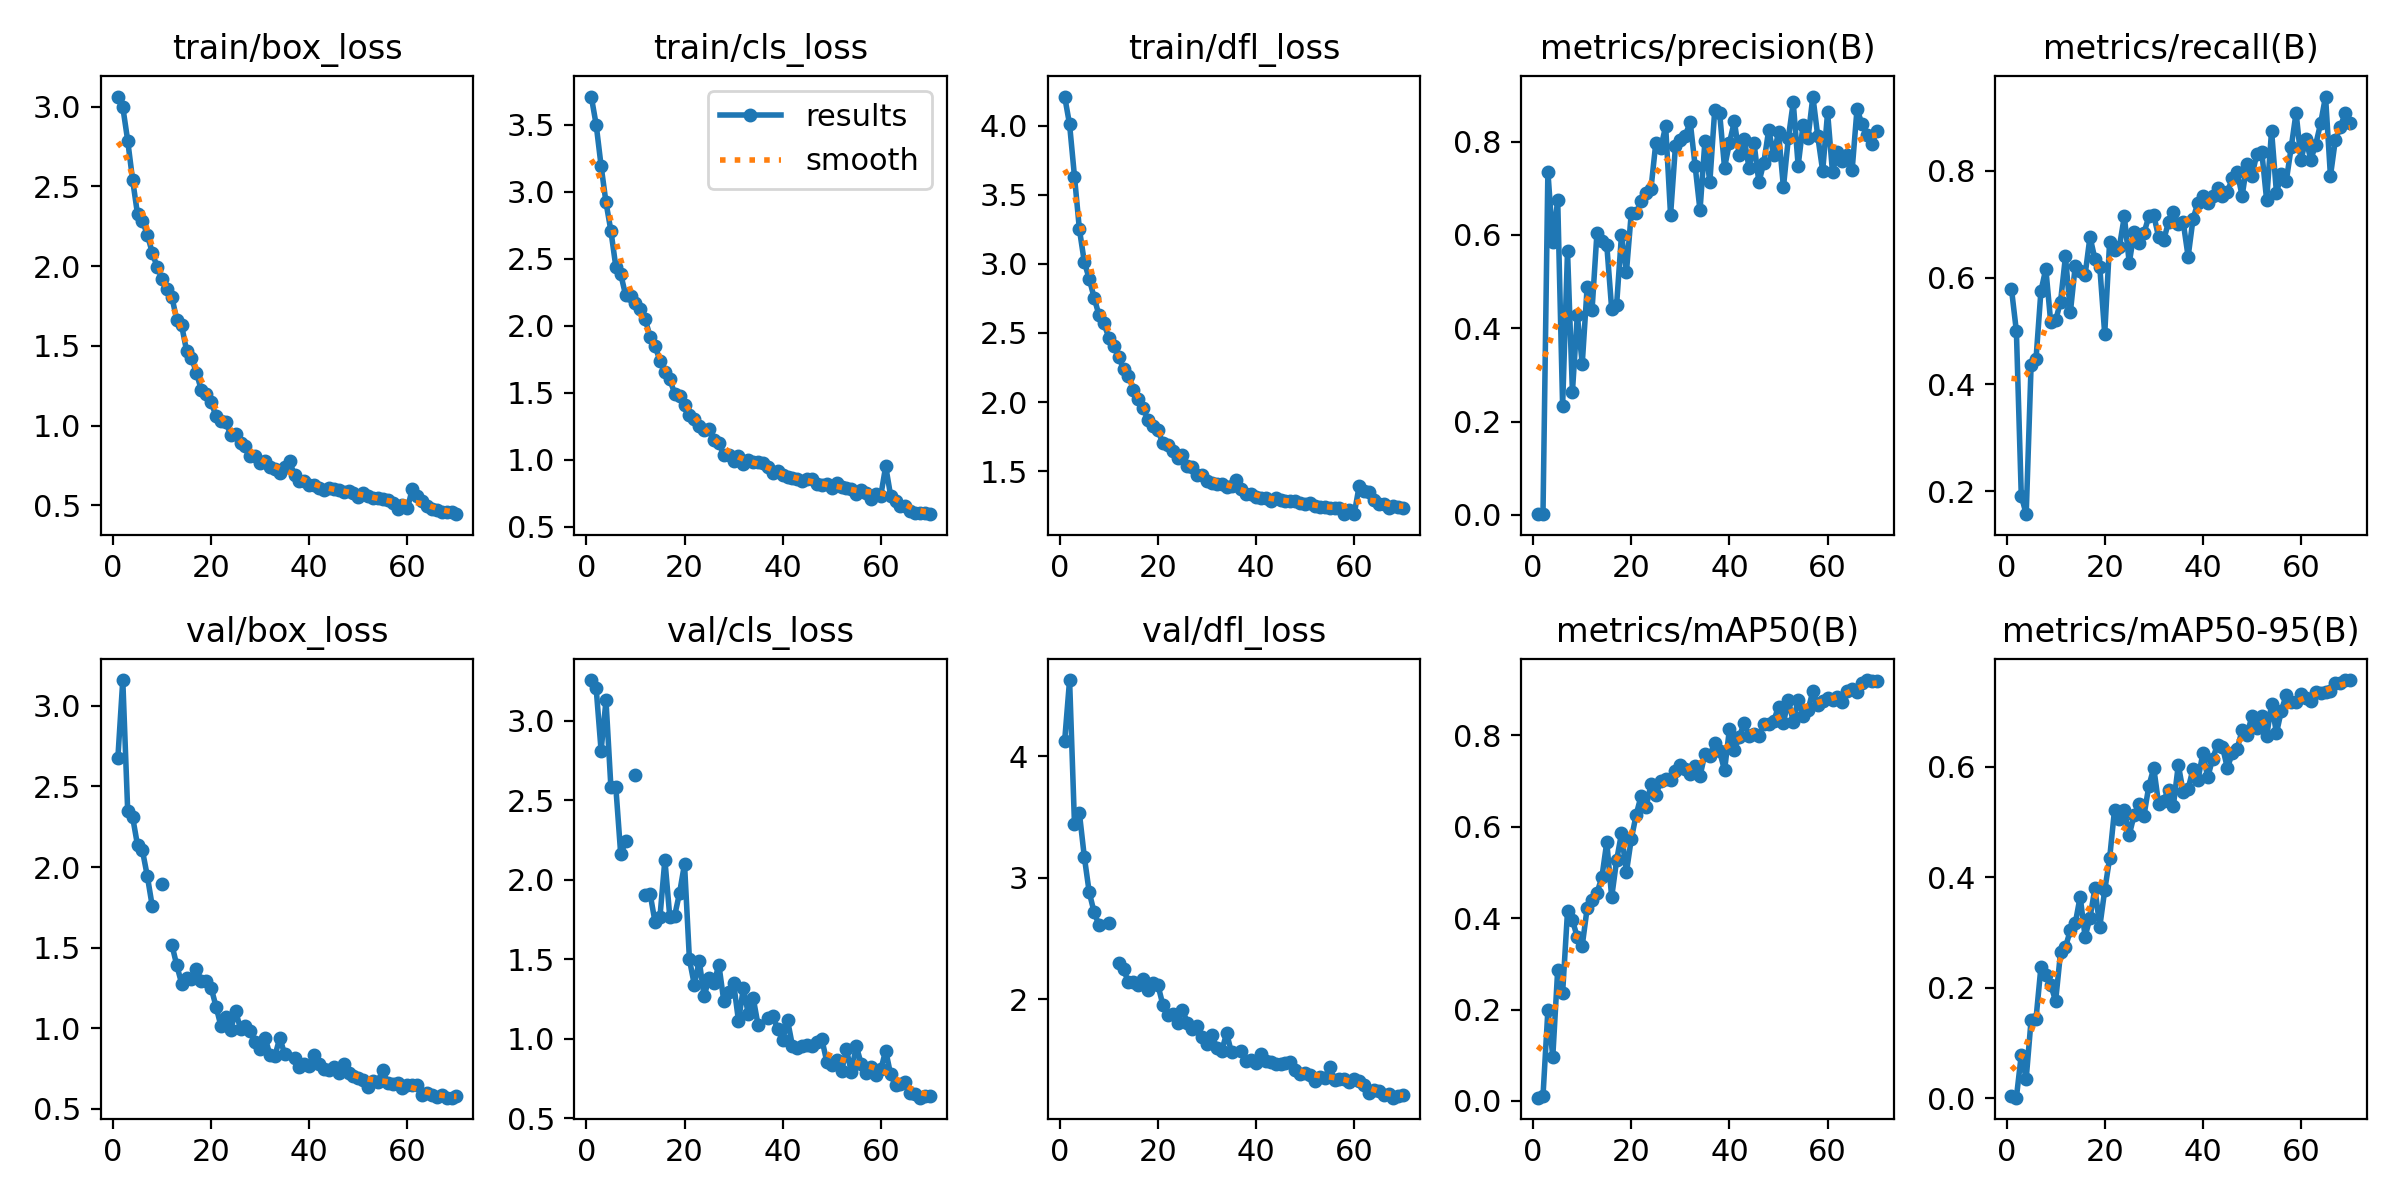

In [12]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [13]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['normal', 'shoplifting']

In [14]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [15]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7899689656601508
mAP 50 0.9057777890896068
mAP 75 0.9041899805391667


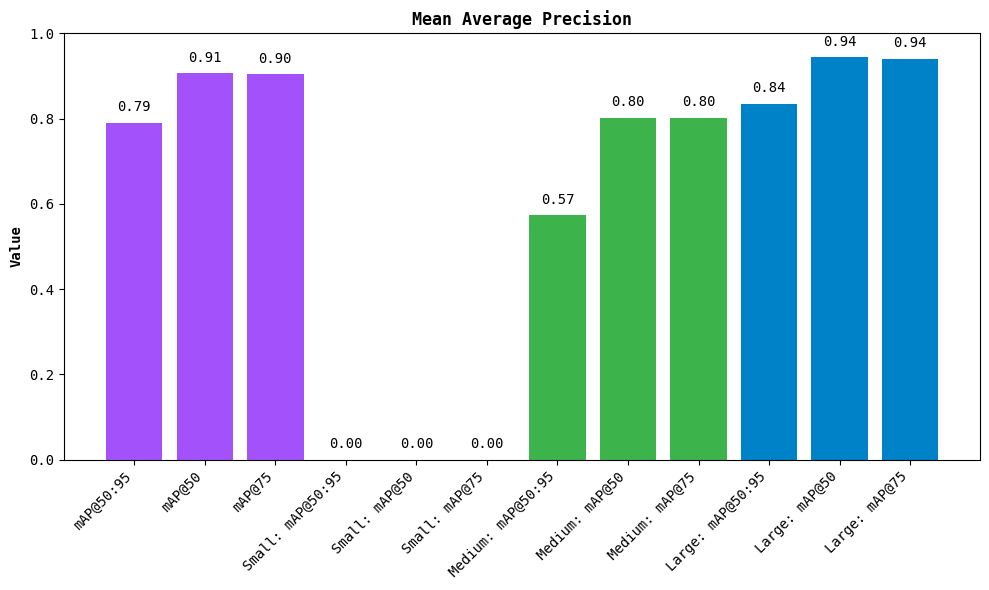

In [16]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [17]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

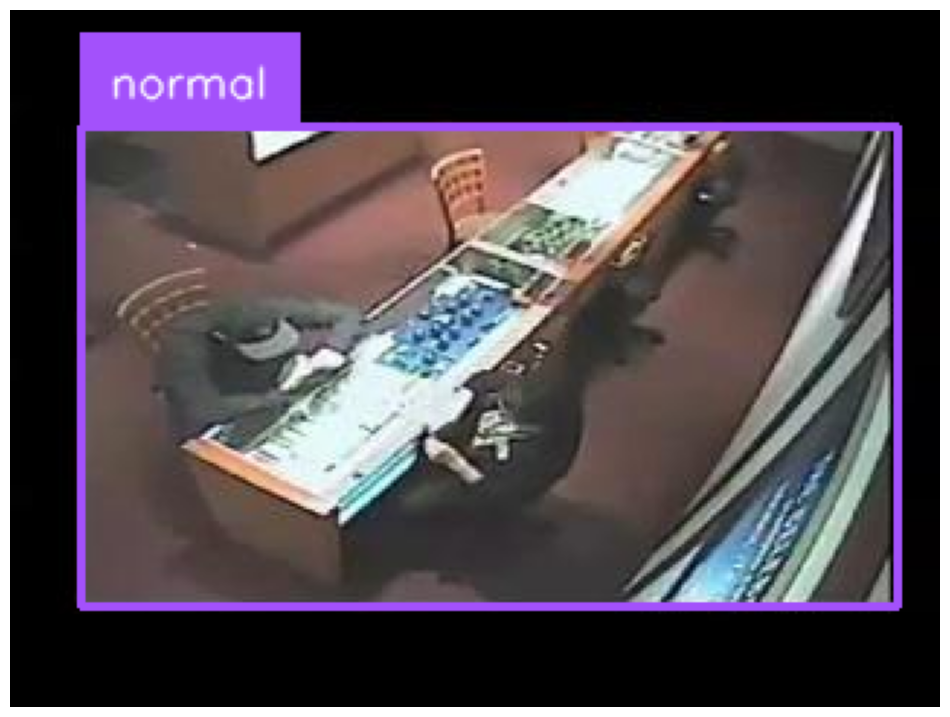

In [24]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')